**Let's check the GPUs**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Mar 11 14:31:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   41C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**IMPORT NECESSARY LIBRARIES**

In [ ]:
# Standard library imports
from datetime import datetime
import os
import random
import shutil
from pathlib import Path
from typing import Tuple, List, Dict, Union

# Scientific computing and numerical operations
import numpy as np

# PyTorch core modules
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


# PyTorch utilities
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR

# Computer vision and image processing
from PIL import Image
from torchvision import transforms
from torchvision.models import alexnet
from torchvision import datasets

# Evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


**Define the constants**

In [ ]:
DATASET_PATH = Path('/content/drive/MyDrive/fall_no_fall_split')

In [ ]:
# Constants
CLASS_LABELS: Dict[str, int] = {"no_fall": 0, "fall": 1}

# Normalization options

TRANSFORMS_DATASET_NORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Scales pixels from [0, 255] to [0, 1]
    transforms.Normalize(mean=[0.5288, 0.5161, 0.4727], std=[0.2366, 0.2398, 0.2436])
])



In [ ]:
SEED = 42  # Set a fixed seed for reproducibility

random.seed(42)  # Set seed for Python's built-in random module
np.random.seed(42)  # Set seed for NumPy random operations
torch.manual_seed(42)  # Set seed for PyTorch CPU operations
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)  # Set seed for all CUDA devices

torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for cuDNN
torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking for consistency


**Define the dataset class**

In [ ]:
class BinaryFallDataset(Dataset):
    def __init__(self,
                 root_directory_path: Path,
                 subset: str,
                 image_transforms: transforms.Compose = TRANSFORMS_DATASET_NORM) -> None:
        """
        Initialize the dataset with parameters only (no data loading).

        Args:
            root_directory_path (str | Path): Path to dataset directory containing 'train', 'validation', and 'test' subfolders.
            subset (str, optional): Which subset to use: 'train', 'validation', or 'test'. Defaults to 'train'.
            image_transforms (transforms.Compose, optional): Transformations for images. Defaults to [-1, 1] normalization.
        """
        self.root_directory_path = Path(root_directory_path)
        self.subset = subset  # "train", "validation", or "test"
        self.image_transforms = TRANSFORMS_DATASET_NORM
        self.image_file_paths: List[Path] = []
        self.class_labels: List[int] = []
        self.is_data_loaded = False

    def load_dataset(self) -> None:
        """Load image file paths and labels from the dataset directory for the selected subset."""
        if self.is_data_loaded:
            return  # Avoid reloading

        subset_directory = self.root_directory_path / self.subset
        if not subset_directory.exists():
            raise FileNotFoundError(f"Subset directory '{subset_directory}' not found.")

        # For each class (fall, no_fall), collect all PNG files
        for class_name, class_label in CLASS_LABELS.items():
            class_directory = subset_directory / class_name
            if not class_directory.exists():
                raise FileNotFoundError(f"Directory '{class_directory}' not found.")

            image_files_in_class = list(class_directory.rglob("*.png"))
            self.image_file_paths.extend(image_files_in_class)
            self.class_labels.extend([class_label] * len(image_files_in_class))

        if not self.image_file_paths:
            raise ValueError("No images found in the dataset directory!")

        self.is_data_loaded = True

    def __len__(self) -> int:
        if not self.is_data_loaded:
            raise RuntimeError("Dataset not loaded. Call `load_dataset()` first.")
        return len(self.image_file_paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Load and transform a single image on demand."""
        if not self.is_data_loaded:
            raise RuntimeError("Dataset not loaded. Call `load_dataset()` first.")

        image_file_path = self.image_file_paths[index]
        class_label = self.class_labels[index]

        image_data = Image.open(image_file_path).convert("RGB")
        image_tensor = self.image_transforms(image_data) if self.image_transforms else image_data

        return image_tensor, class_label

    def get_data_loader(self, batch_size: int = 16, shuffle_data: bool = True) -> DataLoader:
        """Return a DataLoader with minimal RAM usage."""
        if not self.is_data_loaded:
            self.load_dataset()

        return DataLoader(self, batch_size=batch_size, shuffle=shuffle_data, num_workers=2, pin_memory=True, prefetch_factor=2)


**Define the metric calculations**

In [ ]:
def numpy_sigmoid(logits):
    return 1 / (1 + np.exp(-logits))


In [ ]:
class MetricsCalculator:
    """Computes and stores binary classification metrics for fall detection using scikit-learn."""
    def __init__(self) -> None:
        """Initialize lists to store predictions and ground truth labels."""
        self.ground_truth: List[int] = []
        self.model_prediction: List[int] = []

    def convert_logits(self, logits: Union[np.ndarray, torch.Tensor], targets: Union[np.ndarray, torch.Tensor], threshold: float = 0.5) -> None:
        """
        Converts raw logits to binary predictions using a sigmoid threshold
        and updates the stored ground truth and prediction lists.

        Args:
            logits (np.ndarray or torch.Tensor): Raw model outputs with shape [batch_size, 1].
            targets (np.ndarray or torch.Tensor): Ground truth labels with shape [batch_size, 1] or [batch_size].
            threshold (float): Threshold for converting probabilities to binary predictions (default: 0.5).
        """
        # Convert PyTorch tensors to NumPy arrays if necessary
        if isinstance(logits, torch.Tensor):
            logits = logits.detach().cpu().numpy()
        if isinstance(targets, torch.Tensor):
            targets = targets.detach().cpu().numpy()

        # Validate input shapes
        if logits.ndim != 2 or logits.shape[1] != 1:
            raise ValueError(f"Logits must have shape [batch_size, 1], got {logits.shape}")
        if targets.shape[0] != logits.shape[0]:
            raise ValueError(f"Targets batch size ({targets.shape[0]}) must match logits ({logits.shape[0]})")

        # Apply sigmoid to convert logits to probabilities
        probabilities = numpy_sigmoid(logits)

        # Threshold probabilities to obtain binary predictions
        predicted_labels = (probabilities >= threshold).astype(int).flatten()

        # Flatten targets (if not already 1D) and update lists
        targets_list = targets.flatten().tolist()
        predicted_labels_list = predicted_labels.tolist()

        self.ground_truth.extend(targets_list)
        self.model_prediction.extend(predicted_labels_list)

    def precision(self) -> float:
        """Compute Precision = TP / (TP + FP)."""
        return precision_score(self.ground_truth, self.model_prediction, zero_division=0)

    def recall(self) -> float:
        """Compute Recall = TP / (TP + FN)."""
        return recall_score(self.ground_truth, self.model_prediction, zero_division=0)

    def f1_score(self) -> float:
        """Compute F1 Score = 2 * (Precision * Recall) / (Precision + Recall)."""
        return f1_score(self.ground_truth, self.model_prediction, zero_division=0)

    def accuracy(self) -> float:
        """Compute Accuracy = (TP + TN) / Total Samples."""
        return accuracy_score(self.ground_truth, self.model_prediction)

    def confusion_matrix(self) -> np.ndarray:
        return confusion_matrix(self.ground_truth, self.model_prediction)

    def reset(self) -> None:
        """Reset stored predictions and ground truth labels."""
        self.ground_truth = []
        self.model_prediction = []




In [ ]:
dummy_logits = np.array([[0.2], [1.5], [-0.5], [0.0], [2.0]])
dummy_targets = np.array([0, 1, 0, 0, 1])

# Expected behavior:
# Sigmoid(0.2) ~ 0.55 -> prediction: 1
# Sigmoid(1.5) ~ 0.82 -> prediction: 1
# Sigmoid(-0.5) ~ 0.38 -> prediction: 0
# Sigmoid(0.0)  = 0.50 -> prediction: 1 (since threshold is 0.5 and we use >=)
# Sigmoid(2.0) ~ 0.88 -> prediction: 1
#
# Ground truth: [0, 1, 0, 0, 1]
# Predictions:  [1, 1, 0, 1, 1]
#
# Therefore, confusion matrix should be:
#   [[TN, FP],
#    [FN, TP]] = [[1, 2],
#                 [0, 2]]


# Instantiate the MetricsCalculator
metrics = MetricsCalculator()

# Convert logits to binary predictions and store them along with ground truth
metrics.convert_logits(dummy_logits, dummy_targets, threshold=0.5)

# Retrieve and print the confusion matrix
cm = metrics.confusion_matrix()
print("Confusion Matrix:")
print(cm)

# Also print other metrics for verification
print("Accuracy:", metrics.accuracy())
print("Precision:", metrics.precision())
print("Recall:", metrics.recall())
print("F1 Score:", metrics.f1_score())

Confusion Matrix:
[[1 2]
 [0 2]]
Accuracy: 0.6
Precision: 0.5
Recall: 1.0
F1 Score: 0.6666666666666666


**`Define the network `**

In [ ]:
class AlexFallNet(nn.Module):

    def __init__(self) -> None:
        super(AlexFallNet, self).__init__()

        self.alexnet = alexnet(weights=None)

        # Modify the final classifier layer for binary classification (1 logit)
        self.alexnet.classifier[6] = nn.Linear(4096, 1)  # Output 1 logit for BCEWithLogitsLoss

    def forward(self, input_tensor: Tensor) -> Tensor:
        """Forward pass of AlexFallNet.

        Args:
            input_tensor (Tensor): Batch of images with shape [batch_size, 3, 224, 224].

        Returns:
            Tensor: Model predictions (logits) with shape [batch_size, 1].
        """
        return self.alexnet(input_tensor)

In [ ]:
def overfit_single_batch(model, dataloader, criterion, optimizer, scheduler, device, epochs=100, patience=10):
    # Retrieve the batch at index 1 (the second batch)
    single_batch = None
    for index, (images, labels) in enumerate(dataloader):
        if index == 1:
            labels = labels.float().unsqueeze(1)
            single_batch = (images.to(device), labels.to(device))
            break
    if single_batch is None:
        raise RuntimeError("Batch with index 1 not found in the dataloader.")

    batch_images, batch_labels = single_batch

    # Initialize early stopping variables
    best_loss = float('inf')
    patience_counter = 0

    # Overfit on this single batch for the specified number of epochs
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        print(f"Overfit Epoch {epoch+1}/{epochs} - Loss: {loss.item():.6f}")
        scheduler.step(loss)  # Adjust learning rate based on loss

        # Early stopping check
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0  # Reset counter if loss improves
        else:
            patience_counter += 1  # Increase counter if loss doesn't improve

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best loss: {best_loss:.6f}")
            break  # Stop training

def main():
    model = AlexFallNet()
    model.train()

    dataset = BinaryFallDataset(root_directory_path=DATASET_PATH, subset="train")
    dataset.load_dataset()
    data_loader = dataset.get_data_loader(batch_size=16)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    overfit_single_batch(model, data_loader, criterion, optimizer, scheduler, device, epochs=100, patience=10)

if __name__ == "__main__":
    main()


Overfit Epoch 1/100 - Loss: 0.692013
Overfit Epoch 2/100 - Loss: 0.690719
Overfit Epoch 3/100 - Loss: 0.691927
Overfit Epoch 4/100 - Loss: 0.687068
Overfit Epoch 5/100 - Loss: 0.686484
Overfit Epoch 6/100 - Loss: 0.685977
Overfit Epoch 7/100 - Loss: 0.684040
Overfit Epoch 8/100 - Loss: 0.681902
Overfit Epoch 9/100 - Loss: 0.681187
Overfit Epoch 10/100 - Loss: 0.676076
Overfit Epoch 11/100 - Loss: 0.674218
Overfit Epoch 12/100 - Loss: 0.675454
Overfit Epoch 13/100 - Loss: 0.674348
Overfit Epoch 14/100 - Loss: 0.669640
Overfit Epoch 15/100 - Loss: 0.667673
Overfit Epoch 16/100 - Loss: 0.655898
Overfit Epoch 17/100 - Loss: 0.658330
Overfit Epoch 18/100 - Loss: 0.652136
Overfit Epoch 19/100 - Loss: 0.652927
Overfit Epoch 20/100 - Loss: 0.636249
Overfit Epoch 21/100 - Loss: 0.633523
Overfit Epoch 22/100 - Loss: 0.620658
Overfit Epoch 23/100 - Loss: 0.615574
Overfit Epoch 24/100 - Loss: 0.595016
Overfit Epoch 25/100 - Loss: 0.569509
Overfit Epoch 26/100 - Loss: 0.559337
Overfit Epoch 27/100 

**Setup tensorboard for monitoring**

In [ ]:
%load_ext tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

LOG_DIRECTORY = Path("/content/drive/MyDrive/tensorboard_logs/training_experiment")


# Create TensorBoard writer
writer = SummaryWriter(log_dir=LOG_DIRECTORY)

**Define training hyper parameters**

In [ ]:
# Training hyperparameters
BATCH_SIZE = 16
NUMBER_OF_EPOCHS = 100
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 5e-3

# Early stopping settings
EARLY_STOP_PATIENCE = 8

# Learning rate scheduler settings
SCHEDULER_STEP = 4
SCHEDULER_GAMMA = 0.5

In [ ]:
class Trainer:
    def __init__(self, model, training_loader, validation_loader, loss_criterion, computing_device, metrics_calculator):
        """Initialize the trainer with model, data, and settings."""
        self.model = model.to(computing_device)
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.loss_criterion = loss_criterion
        self.optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA)
        self.computing_device = computing_device
        self.number_of_epochs = NUMBER_OF_EPOCHS
        self.early_stopping_patience = EARLY_STOP_PATIENCE
        self.tensorboard_writer = SummaryWriter()
        self.metrics_calculator = metrics_calculator

        # Create directory in Google Drive to save model
        self.experiment_path = self.create_experiment_folder()

    def create_experiment_folder(self):
        """Creates an experiment folder in Google Drive with timestamp."""

        # Define base path and timestamp
        base_path = "/content/drive/MyDrive/experiment"
        timestamp = datetime.now().strftime("exp_%d_%m_%Y_%H_%M")
        experiment_path = os.path.join(base_path, timestamp)

        # Create folder if it doesn't exist
        os.makedirs(experiment_path, exist_ok=True)
        print(f"Experiment directory created at: {experiment_path}")

        return experiment_path

    def train_one_epoch(self):
        """Train the model for one epoch and return only the loss."""
        self.model.train()
        total_training_loss = 0.0

        for images, labels in self.training_loader:
            images = images.to(self.computing_device)
            labels = labels.to(self.computing_device).float().unsqueeze(1)  # For BCEWithLogitsLoss

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.loss_criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_training_loss += loss.item() * images.size(0)

        average_training_loss = total_training_loss / len(self.training_loader.dataset)
        return average_training_loss

    def validate_one_epoch(self):
        """Validate the model and return loss plus all metrics."""
        self.model.eval()
        self.metrics_calculator.reset()
        total_validation_loss = 0.0

        with torch.no_grad():
            for images, labels in self.validation_loader:
                images = images.to(self.computing_device)
                labels = labels.to(self.computing_device).float().unsqueeze(1)
                outputs = self.model(images)
                loss = self.loss_criterion(outputs, labels)

                total_validation_loss += loss.item() * images.size(0)
                self.metrics_calculator.convert_logits(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy())

        average_validation_loss = total_validation_loss / len(self.validation_loader.dataset)
        validation_accuracy = self.metrics_calculator.accuracy()
        validation_precision = self.metrics_calculator.precision()
        validation_recall = self.metrics_calculator.recall()
        validation_f1_score = self.metrics_calculator.f1_score()
        return average_validation_loss, validation_accuracy, validation_precision, validation_recall, validation_f1_score

    def train_full_cycle(self):
        """Run the full training loop with early stopping."""
        best_validation_loss = float('inf')
        epochs_without_improvement = 0
        print("device: ", computing_device)

        for epoch in range(self.number_of_epochs):
            print(f"\n=== Epoch {epoch + 1}/{self.number_of_epochs} ===")

            # Train (only loss) and validate (loss + metrics)
            training_loss = self.train_one_epoch()
            validation_loss, validation_accuracy, validation_precision, validation_recall, validation_f1_score = self.validate_one_epoch()
            self.scheduler.step()

            # Log to TensorBoard
            self.tensorboard_writer.add_scalars("Loss", {"Training": training_loss, "Validation": validation_loss}, epoch)
            self.tensorboard_writer.add_scalar("Validation/Accuracy", validation_accuracy, epoch)
            self.tensorboard_writer.add_scalar("Validation/Precision", validation_precision, epoch)
            self.tensorboard_writer.add_scalar("Validation/Recall", validation_recall, epoch)
            self.tensorboard_writer.add_scalar("Validation/F1 Score", validation_f1_score, epoch)

            # Print metrics (training loss only, full validation metrics)
            print(f"Training   - Loss: {training_loss:.4f}")
            print(f"Validation - Loss: {validation_loss:.4f} | Accuracy: {validation_accuracy:.4f} | Precision: {validation_precision:.4f} | Recall: {validation_recall:.4f} | F1: {validation_f1_score:.4f}")

            # Early stopping and model saving based on validation loss
            if validation_loss < best_validation_loss:
                best_validation_loss = validation_loss
                epochs_without_improvement = 0
                model_save_path = os.path.join(self.experiment_path, "best_model.pth")
                torch.save(self.model.state_dict(), model_save_path)
                print(f"=> Saved best model at: {model_save_path}")
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= self.early_stopping_patience:
                    print("Early stopping triggered.")
                    break

        self.tensorboard_writer.close()
        print("\nTraining completed!")

In [ ]:
if __name__ == "__main__":
    # Replace with your actual dataset path
    computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize datasets
    training_dataset = BinaryFallDataset(DATASET_PATH, subset="train")
    validation_dataset = BinaryFallDataset(DATASET_PATH, subset="validation")
    training_dataset.load_dataset()
    validation_dataset.load_dataset()

    # Get data loaders
    training_loader = training_dataset.get_data_loader(batch_size=BATCH_SIZE, shuffle_data=True)
    validation_loader = validation_dataset.get_data_loader(batch_size=BATCH_SIZE, shuffle_data=True)

    # Initialize model, criterion, and metrics
    model = AlexFallNet()
    loss_criterion = nn.BCEWithLogitsLoss()
    metrics_calculator = MetricsCalculator()

    # Initialize and run trainer
    trainer = Trainer(
        model=model,
        training_loader=training_loader,
        validation_loader=validation_loader,
        loss_criterion=loss_criterion,
        computing_device=computing_device,
        metrics_calculator=metrics_calculator
    )
    trainer.train_full_cycle()

Experiment directory created at: /content/drive/MyDrive/experiment/exp_11_03_2025_10_09
device:  cuda

=== Epoch 1/100 ===
Training   - Loss: 0.1948
Validation - Loss: 0.0995 | Accuracy: 0.9669 | Precision: 0.9871 | Recall: 0.9495 | F1: 0.9679
=> Saved best model at: /content/drive/MyDrive/experiment/exp_11_03_2025_10_09/best_model.pth

=== Epoch 2/100 ===
Training   - Loss: 0.0797
Validation - Loss: 0.0671 | Accuracy: 0.9778 | Precision: 0.9799 | Recall: 0.9779 | F1: 0.9789
=> Saved best model at: /content/drive/MyDrive/experiment/exp_11_03_2025_10_09/best_model.pth

=== Epoch 3/100 ===
Training   - Loss: 0.0555
Validation - Loss: 0.0531 | Accuracy: 0.9818 | Precision: 0.9950 | Recall: 0.9703 | F1: 0.9825
=> Saved best model at: /content/drive/MyDrive/experiment/exp_11_03_2025_10_09/best_model.pth

=== Epoch 4/100 ===
Training   - Loss: 0.0472
Validation - Loss: 0.0465 | Accuracy: 0.9880 | Precision: 0.9958 | Recall: 0.9813 | F1: 0.9885
=> Saved best model at: /content/drive/MyDrive/e

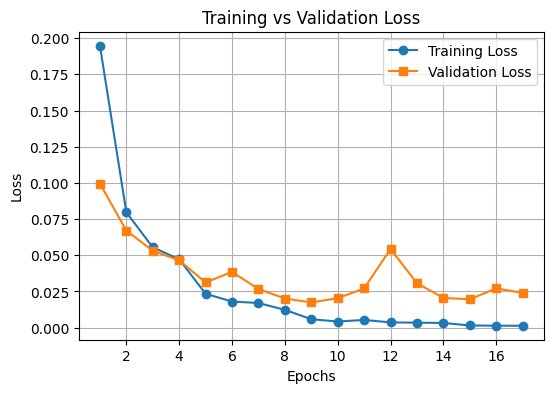

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 18))

# Training and Validation Loss
training_loss = [0.1948, 0.0797, 0.0555, 0.0472, 0.0234, 0.0180, 0.0170, 0.0123, 0.0058, 0.0042,
                 0.0053, 0.0036, 0.0034, 0.0032, 0.0015, 0.0013, 0.0013]
validation_loss = [0.0995, 0.0671, 0.0531, 0.0465, 0.0312, 0.0385, 0.0267, 0.0201, 0.0174, 0.0203,
                   0.0271, 0.0543, 0.0307, 0.0205, 0.0196, 0.0271, 0.0240]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(epochs, training_loss, label="Training Loss", marker="o")
plt.plot(epochs, validation_loss, label="Validation Loss", marker="s")

# Labels and Title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


***THIRD EXP***

In [ ]:
if __name__ == "__main__":
    # Replace with your actual dataset path
    computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize datasets
    training_dataset = BinaryFallDataset(DATASET_PATH, subset="train")
    validation_dataset = BinaryFallDataset(DATASET_PATH, subset="validation")
    training_dataset.load_dataset()
    validation_dataset.load_dataset()

    # Get data loaders
    training_loader = training_dataset.get_data_loader(batch_size=BATCH_SIZE, shuffle_data=True)
    validation_loader = validation_dataset.get_data_loader(batch_size=BATCH_SIZE, shuffle_data=True)

    # Initialize model, criterion, and metrics
    model = AlexFallNet()
    loss_criterion = nn.BCEWithLogitsLoss()
    metrics_calculator = MetricsCalculator()

    # Initialize and run trainer
    trainer = Trainer(
        model=model,
        training_loader=training_loader,
        validation_loader=validation_loader,
        loss_criterion=loss_criterion,
        computing_device=computing_device,
        metrics_calculator=metrics_calculator
    )
    trainer.train_full_cycle()

Experiment directory created at: /content/drive/MyDrive/experiment/exp_11_03_2025_12_16
device:  cuda

=== Epoch 1/100 ===
Training   - Loss: 0.2207
Validation - Loss: 0.1142 | Accuracy: 0.9632 | Precision: 0.9686 | Recall: 0.9613 | F1: 0.9649
=> Saved best model at: /content/drive/MyDrive/experiment/exp_11_03_2025_12_16/best_model.pth

=== Epoch 2/100 ===
Training   - Loss: 0.0879
Validation - Loss: 0.1143 | Accuracy: 0.9621 | Precision: 0.9558 | Recall: 0.9730 | F1: 0.9644

=== Epoch 3/100 ===
Training   - Loss: 0.0660
Validation - Loss: 0.0560 | Accuracy: 0.9825 | Precision: 0.9874 | Recall: 0.9793 | F1: 0.9833
=> Saved best model at: /content/drive/MyDrive/experiment/exp_11_03_2025_12_16/best_model.pth

=== Epoch 4/100 ===
Training   - Loss: 0.0557
Validation - Loss: 0.0788 | Accuracy: 0.9778 | Precision: 0.9894 | Recall: 0.9682 | F1: 0.9787

=== Epoch 5/100 ===
Training   - Loss: 0.0319
Validation - Loss: 0.0452 | Accuracy: 0.9847 | Precision: 0.9802 | Recall: 0.9910 | F1: 0.9856


**Evaluation and metrics on test set**

In [ ]:
WEIGHTS_PATH = Path('/content/drive/MyDrive/experiment/exp_11_03_2025_12_16/best_model.pth')

In [ ]:
class Evaluation:
    def __init__(self, model, evaluation_loader, loss_criterion, computing_device, metrics_calculator):
        """Initialize the evaluator with model, data, and settings."""
        self.model = model.to(computing_device)
        self.evaluation_loader = evaluation_loader
        self.loss_criterion = loss_criterion
        self.computing_device = computing_device
        self.metrics_calculator = metrics_calculator

    def evaluate(self):
        """Evaluate the model on the evaluation dataset and return loss, metrics, and confusion matrix."""
        self.model.eval()
        self.metrics_calculator.reset()
        total_evaluation_loss = 0.0

        with torch.no_grad():
            for images, labels in self.evaluation_loader:
                images = images.to(self.computing_device)
                labels = labels.to(self.computing_device).float().unsqueeze(1)  # For BCEWithLogitsLoss

                outputs = self.model(images)
                loss = self.loss_criterion(outputs, labels)

                total_evaluation_loss += loss.item() * images.size(0)
                self.metrics_calculator.convert_logits(outputs.detach().cpu().numpy(), labels.detach().cpu().numpy())

        # Compute average loss and metrics
        average_evaluation_loss = total_evaluation_loss / len(self.evaluation_loader.dataset)
        evaluation_accuracy = self.metrics_calculator.accuracy()
        evaluation_precision = self.metrics_calculator.precision()
        evaluation_recall = self.metrics_calculator.recall()
        evaluation_f1_score = self.metrics_calculator.f1_score()
        evaluation_confusion_matrix = self.metrics_calculator.confusion_matrix()

        return (
            average_evaluation_loss,
            evaluation_accuracy,
            evaluation_precision,
            evaluation_recall,
            evaluation_f1_score,
            evaluation_confusion_matrix
        )

    def print_evaluation_results(self):
        """Print the evaluation results in a formatted way."""
        (
            loss,
            accuracy,
            precision,
            recall,
            f1_score,
            confusion_matrix
        ) = self.evaluate()

        print("\n=== Evaluation Results ===")
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1_score:.4f}")
        print("\nConfusion Matrix:")
        print("[[TN, FP]")
        print(" [FN, TP]]")
        print(f"{confusion_matrix[0][0]:4d}  {confusion_matrix[0][1]:4d}")
        print(f"{confusion_matrix[1][0]:4d}  {confusion_matrix[1][1]:4d}")
        print("\nWhere:")
        print(f"TN (True Negatives)  = {confusion_matrix[0][0]:4d} : Correctly predicted negatives")
        print(f"FP (False Positives) = {confusion_matrix[0][1]:4d} : Negatives predicted as positives")
        print(f"FN (False Negatives) = {confusion_matrix[1][0]:4d} : Positives predicted as negatives")
        print(f"TP (True Positives)  = {confusion_matrix[1][1]:4d} : Correctly predicted positives")
        print("======================")


In [ ]:
# Load trained model
model = AlexFallNet()
computing_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_criterion = nn.BCEWithLogitsLoss()
metrics_calculator = MetricsCalculator()

model.load_state_dict(torch.load("/content/drive/MyDrive/experiment/exp_11_03_2025_12_16/best_model.pth", weights_only=True))
model.to(computing_device)

# Test dataset and DataLoader (from BinaryFallDataset)
test_dataset = BinaryFallDataset(root_directory_path=Path(DATASET_PATH), subset="test")
test_dataset.load_dataset()
test_loader = test_dataset.get_data_loader(batch_size=32, shuffle_data=False)

# Create evaluator
evaluator = Evaluation(
    model=model,
    evaluation_loader=test_loader,
    loss_criterion=loss_criterion,
    computing_device=computing_device,
    metrics_calculator=metrics_calculator
)

# Run evaluation and print results
evaluator.print_evaluation_results()


=== Evaluation Results ===
Loss: 0.0210
Accuracy: 0.9927
Precision: 0.9951
Recall: 0.9910
F1 Score: 0.9931

Confusion Matrix:
[[TN, FP]
 [FN, TP]]
1295     7
  13  1434

Where:
TN (True Negatives)  = 1295 : Correctly predicted negatives
FP (False Positives) =    7 : Negatives predicted as positives
FN (False Negatives) =   13 : Positives predicted as negatives
TP (True Positives)  = 1434 : Correctly predicted positives


1295 - **TN**
13 - **FN**
1434 - **TP**
7 - ***FP***